In [1]:
import tensorflow as tf
import numpy as np
from patchify import patchify
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4,5"
import segmentation_models as sm
from matplotlib import pyplot as plt
import warnings
import gc
warnings.filterwarnings("ignore")

2024-11-25 10:03:41.449005: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 10:03:41.468411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732496621.490483 3617514 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732496621.497105 3617514 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 10:03:41.520457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Segmentation Models: using `tf.keras` framework.


## Load Dataset

In [2]:
images_dir = "dataset/train_images_norm_12/"
masks_dir = "dataset/train_combined_mask/"

In [3]:
images = []
masks = []

for i in range(50):
    images.append(np.load(images_dir+f"train_{i}.tif.npy"))
    masks.append(np.load(masks_dir+f"train_combined_mask_{i}.npy"))

broken_dataset = [42, 38]

for i in broken_dataset:
    images.pop(i)
    masks.pop(i)

print(np.array(images[0]).shape, np.array(masks[0]).shape)

(804, 981, 12) (804, 981, 1)


## Patchify the Dataset

In [4]:
patch_size = 256

def create_patches(images, patch_size):
    patched_images = []
    for image in images:
        pad_height = (patch_size - image.shape[0] % patch_size) % patch_size
        pad_width = (patch_size - image.shape[1] % patch_size) % patch_size
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
        
        patches = patchify(padded_image, (patch_size, patch_size, 12), step=patch_size)
        patched_images.extend(patches.reshape(-1, patch_size, patch_size, 12))
    
    return np.array(patched_images)

def create_mask_patches(masks, patch_size):
    patched_masks = []
    for mask in masks:
        pad_height = (patch_size - mask.shape[0] % patch_size) % patch_size
        pad_width = (patch_size - mask.shape[1] % patch_size) % patch_size
        padded_mask = np.pad(mask, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
        
        patches = patchify(padded_mask, (patch_size, patch_size, 1), step=patch_size)
        patched_masks.extend(patches.reshape(-1, patch_size, patch_size, 1))
    
    return np.array(patched_masks)

patched_images = create_patches(images, patch_size)
patched_labels = create_mask_patches(masks, patch_size)

del images, masks

## One Hot Encoding

In [5]:
from tensorflow.keras.utils import to_categorical

In [6]:
num_classes = len(np.unique(patched_labels))
num_classes

3

In [7]:
patched_labels_categorical = to_categorical(patched_labels, num_classes=num_classes)

In [8]:
del patched_labels
gc.collect()

11

## Convert to TF Dataset

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((patched_images, patched_labels_categorical))
dataset

I0000 00:00:1732496636.041113 3617514 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78789 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:3a:00.0, compute capability: 9.0
I0000 00:00:1732496636.043218 3617514 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78789 MB memory:  -> device: 1, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:5d:00.0, compute capability: 9.0
I0000 00:00:1732496636.045122 3617514 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78789 MB memory:  -> device: 2, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:9a:00.0, compute capability: 9.0
I0000 00:00:1732496636.047056 3617514 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 72218 MB memory:  -> device: 3, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:ab:00.0, compute capability: 9.0


<_TensorSliceDataset element_spec=(TensorSpec(shape=(256, 256, 12), dtype=tf.float64, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float64, name=None))>

In [10]:
del patched_images, patched_labels_categorical
gc.collect()

0

In [11]:
for image,_ in dataset.take(1):
    print(np.max(image)) #no need normalize

1.0


2024-11-25 10:04:05.762465: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
train_size = 0.8  # 80% untuk data train
test_size = 1 - train_size  # 20% untuk data test

total_size = len(dataset)

train_count = int(train_size * total_size)
test_count = total_size - train_count

train_dataset = dataset.take(train_count)
test_dataset = dataset.skip(train_count)

del dataset
gc.collect()

0

## Augmentation Dataset

In [13]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # Augmentasi input dan label dengan seed yang sama agar keduanya diproses dengan cara yang sama.
        self.augment_inputs_hor = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels_hor = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_inputs_ver = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)
        self.augment_labels_ver = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)

        self.augment_input_transpose = tf.keras.layers.RandomTranslation(.2, .2, fill_mode="nearest", seed=seed)
        self.augment_labels_transpose = tf.keras.layers.RandomTranslation(.2, .2, fill_mode="nearest", seed=seed)

        # Menambahkan augmentasi lainnya
        self.random_rotation_inputs = tf.keras.layers.RandomRotation(0.2, seed=seed)  # rotasi acak (20%)
        self.random_rotation_labels = tf.keras.layers.RandomRotation(0.2, seed=seed)  # rotasi acak (20%)
        
        self.random_zoom_inputs = tf.keras.layers.RandomZoom(0.2, seed=seed)  # zoom acak (20%)
        self.random_zoom_labels = tf.keras.layers.RandomZoom(0.2, seed=seed)  # zoom acak (20%)

        self.random_contrast_inputs = tf.keras.layers.RandomContrast(.2, seed=seed)
        self.random_contrast_labels = tf.keras.layers.RandomContrast(.2, seed=seed)

    def call(self, inputs, labels):
        # Lakukan augmentasi pada inputs dan labels
        inputs = self.augment_inputs_hor(inputs)
        labels = self.augment_labels_hor(labels)
        
        inputs = self.augment_inputs_ver(inputs)
        labels = self.augment_labels_ver(labels)

        inputs = self.random_rotation_inputs(inputs)
        labels = self.random_rotation_labels(labels)

        inputs = self.random_zoom_inputs(inputs)
        labels = self.random_zoom_labels(labels)
        
        inputs = self.random_contrast_inputs(inputs)
        labels = self.random_contrast_labels(labels)

        return inputs, labels

In [14]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(1000)
    .batch(32)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(32)

## Custome Metric and Losses

In [15]:
import tensorflow.keras.backend as K

In [16]:
def jaccardCoef(y_true, y_pred):
    yTrueF = K.flatten(y_true)
    yPredF = K.flatten(y_pred)
    yTrueF = K.cast(yTrueF, dtype='float32')
    yPredF = K.cast(yPredF, dtype='float32')
    intersection = K.sum(yTrueF * yPredF)
    union = K.sum(yTrueF) + K.sum(yPredF) - intersection
    return (intersection + 1.) / (union + 1.)

In [17]:
weights = [.1666, .1666, .1666]
diceLoss = sm.losses.DiceLoss(class_weights = weights)
focalLoss = sm.losses.CategoricalFocalLoss()
totalLoss = diceLoss + (1 * focalLoss)

## Define Models

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate, Reshape, UpSampling2D
from tensorflow.keras.models import Model
def resnet_unet(input_shape=(256, 256, 6), n_classes=3):
    input_layer = Input(shape=input_shape)
    upscale_input = UpSampling2D(size=(2,2), interpolation="nearest")(input_layer)
    
    resnet = tf.keras.applications.ResNet50(include_top=False, weights=None, input_tensor=upscale_input)

    layer_names = [
        'conv1_relu',
        'conv2_block3_out',
        'conv3_block4_out',
        'conv4_block6_out'
    ]
    encoder_outputs = [resnet.get_layer(name).output for name in layer_names]
    

    encoder = Model(inputs=resnet.input, outputs=encoder_outputs)
    

    inputs = Input(shape=input_shape)
    encoder_outputs = encoder(inputs)
    
    c1, c2, c3, c4 = encoder_outputs

    bridge = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    bridge = Dropout(0.5)(bridge)
    bridge = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(bridge)
    
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bridge)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
    
    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)
    
    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
    c8 = Dropout(0.3)(c8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)
    

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c8)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = resnet_unet(input_shape=(256, 256, 12), n_classes=3)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 256, 256, │  8,617,408 │ input_layer_1[0]… │
│ (Functional)        │ 64), (None, 128,  │            │                   │
│                     │ 128, 256), (None, │            │                   │
│                     │ 64, 64, 512),     │            │                   │
│                     │ (None, 32, 32,    │            │                   │
│                     │ 1024)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │  4,719,104 │ functional[0][3]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ dropout[0][0]     │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    524,544 │ conv2d_1[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 768)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │    131,200 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 384)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    442,496 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 19,445,699 (74.18 MB)

 Trainable params: 19,415,107 (74.06 MB)

 Non-trainable params: 30,592 (119.50 KB)

In [19]:
def pixel_accuracy_softmax(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)  # Shape: (batch_size, height, width)
    y_true = tf.argmax(y_true, axis=-1)  # Shape: (batch_size, height, width)

    correct = tf.reduce_sum(tf.cast(y_true == y_pred, tf.int32))
    total = tf.size(y_true, out_type=tf.int32)

    return correct / total

In [ ]:
EPOCHS = 300
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 2500//32//VAL_SUBSPLITS
STEPS_PER_EPOCH = 2500//32
LR_INIT = 0.001

In [21]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=LR_INIT,
    decay_steps=STEPS_PER_EPOCH * EPOCHS,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",   # Metric to monitor
    patience=20,          # Stop after 15 epochs with no improvement
    mode="min",           # Looking for the lowest val_loss
    restore_best_weights=True  # Restore weights to the best epoch
)

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), loss=totalLoss, metrics=["accuracy", jaccardCoef, pixel_accuracy_softmax])

In [23]:
modelHistory = model.fit(train_batches, steps_per_epoch=STEPS_PER_EPOCH,
                         verbose=1,
                         epochs=EPOCHS, 
                         validation_data = test_batches,validation_steps=VALIDATION_STEPS, callbacks=[early_stopping])

Epoch 1/300


I0000 00:00:1732496669.757977 3618268 service.cc:148] XLA service 0x7f1324002ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732496669.758049 3618268 service.cc:156]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
I0000 00:00:1732496669.758067 3618268 service.cc:156]   StreamExecutor device (1): NVIDIA H100 80GB HBM3, Compute Capability 9.0
I0000 00:00:1732496669.758073 3618268 service.cc:156]   StreamExecutor device (2): NVIDIA H100 80GB HBM3, Compute Capability 9.0
I0000 00:00:1732496669.758079 3618268 service.cc:156]   StreamExecutor device (3): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2024-11-25 10:04:30.536987: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732496673.776027 3618268 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-25 10:05:03.999997: E external/local_xla

22/78 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.6423 - jaccard_coef: 0.4064 - loss: 0.9737 - pixel_accuracy_softmax: 0.6423

2024-11-25 10:06:38.136074: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_3', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads



78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7200 - jaccard_coef: 0.4693 - loss: 0.9509 - pixel_accuracy_softmax: 0.7188

2024-11-25 10:08:22.496771: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


78/78 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.7207 - jaccard_coef: 0.4700 - loss: 0.9507 - pixel_accuracy_softmax: 0.7195 - val_accuracy: 0.7012 - val_jaccard_coef: 0.4111 - val_loss: 0.9488 - val_pixel_accuracy_softmax: 0.6940
Epoch 2/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8322 - jaccard_coef: 0.5909 - loss: 0.9235 - pixel_accuracy_softmax: 0.8321 - val_accuracy: 0.7908 - val_jaccard_coef: 0.5060 - val_loss: 0.9353 - val_pixel_accuracy_softmax: 0.7888
Epoch 3/300


2024-11-25 10:10:23.951999: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


78/78 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8375 - jaccard_coef: 0.6255 - loss: 0.9183 - pixel_accuracy_softmax: 0.8378 - val_accuracy: 0.8179 - val_jaccard_coef: 0.5911 - val_loss: 0.9251 - val_pixel_accuracy_softmax: 0.8147
Epoch 4/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8353 - jaccard_coef: 0.6343 - loss: 0.9165 - pixel_accuracy_softmax: 0.8337 - val_accuracy: 0.8111 - val_jaccard_coef: 0.6060 - val_loss: 0.9256 - val_pixel_accuracy_softmax: 0.8084
Epoch 5/300


2024-11-25 10:14:27.000656: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


78/78 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8462 - jaccard_coef: 0.6600 - loss: 0.9123 - pixel_accuracy_softmax: 0.8465 - val_accuracy: 0.8313 - val_jaccard_coef: 0.6747 - val_loss: 0.9218 - val_pixel_accuracy_softmax: 0.8294
Epoch 6/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8486 - jaccard_coef: 0.6687 - loss: 0.9104 - pixel_accuracy_softmax: 0.8486 - val_accuracy: 0.8354 - val_jaccard_coef: 0.5837 - val_loss: 0.9252 - val_pixel_accuracy_softmax: 0.8309
Epoch 7/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8403 - jaccard_coef: 0.6562 - loss: 0.9120 - pixel_accuracy_softmax: 0.8403 - val_accuracy: 0.8698 - val_jaccard_coef: 0.6936 - val_loss: 0.9098 - val_pixel_accuracy_softmax: 0.8684
Epoch 8/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8525 - jaccard_coef: 0.6802 - loss: 0.9089 - pixel_accuracy_softmax: 0.8535 - val_accuracy: 0.8574 - val_jaccard_coef: 0.6252 - val_loss: 0.9121 - val_pixel_accuracy_softmax: 0.8564
Epoch 9/300


2024-11-25 10:22:32.761613: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


78/78 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8508 - jaccard_coef: 0.6673 - loss: 0.9102 - pixel_accuracy_softmax: 0.8490 - val_accuracy: 0.8580 - val_jaccard_coef: 0.5959 - val_loss: 0.9185 - val_pixel_accuracy_softmax: 0.8551
Epoch 10/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8502 - jaccard_coef: 0.6758 - loss: 0.9090 - pixel_accuracy_softmax: 0.8506 - val_accuracy: 0.8598 - val_jaccard_coef: 0.6465 - val_loss: 0.9105 - val_pixel_accuracy_softmax: 0.8575
Epoch 11/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8516 - jaccard_coef: 0.6755 - loss: 0.9088 - pixel_accuracy_softmax: 0.8519 - val_accuracy: 0.8563 - val_jaccard_coef: 0.6244 - val_loss: 0.9114 - val_pixel_accuracy_softmax: 0.8549
Epoch 12/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8528 - jaccard_coef: 0.6780 - loss: 0.9081 - pixel_accuracy_softmax: 0.8525 - val_accuracy: 0.8629 - val_jaccard_coef: 0.6713 - val_loss: 0.9095 - val_pixel_accuracy_softmax: 0.8614
Epoch 13/300
78/7

2024-11-25 10:38:43.585832: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


78/78 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8592 - jaccard_coef: 0.6902 - loss: 0.9061 - pixel_accuracy_softmax: 0.8590 - val_accuracy: 0.8799 - val_jaccard_coef: 0.6276 - val_loss: 0.9126 - val_pixel_accuracy_softmax: 0.8792
Epoch 18/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8592 - jaccard_coef: 0.6960 - loss: 0.9056 - pixel_accuracy_softmax: 0.8600 - val_accuracy: 0.8623 - val_jaccard_coef: 0.6751 - val_loss: 0.9090 - val_pixel_accuracy_softmax: 0.8622
Epoch 19/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8602 - jaccard_coef: 0.6983 - loss: 0.9051 - pixel_accuracy_softmax: 0.8606 - val_accuracy: 0.8773 - val_jaccard_coef: 0.6601 - val_loss: 0.9073 - val_pixel_accuracy_softmax: 0.8774
Epoch 20/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8603 - jaccard_coef: 0.6943 - loss: 0.9056 - pixel_accuracy_softmax: 0.8599 - val_accuracy: 0.8588 - val_jaccard_coef: 0.6403 - val_loss: 0.9152 - val_pixel_accuracy_softmax: 0.8588
Epoch 21/300
78/7

2024-11-25 11:11:10.827425: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


78/78 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8720 - jaccard_coef: 0.7194 - loss: 0.9016 - pixel_accuracy_softmax: 0.8706 - val_accuracy: 0.8618 - val_jaccard_coef: 0.6260 - val_loss: 0.9203 - val_pixel_accuracy_softmax: 0.8618
Epoch 34/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8710 - jaccard_coef: 0.7168 - loss: 0.9015 - pixel_accuracy_softmax: 0.8708 - val_accuracy: 0.8806 - val_jaccard_coef: 0.6486 - val_loss: 0.9103 - val_pixel_accuracy_softmax: 0.8798
Epoch 35/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8694 - jaccard_coef: 0.7147 - loss: 0.9020 - pixel_accuracy_softmax: 0.8691 - val_accuracy: 0.8113 - val_jaccard_coef: 0.5749 - val_loss: 0.9309 - val_pixel_accuracy_softmax: 0.8103
Epoch 36/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8699 - jaccard_coef: 0.7202 - loss: 0.9016 - pixel_accuracy_softmax: 0.8710 - val_accuracy: 0.8764 - val_jaccard_coef: 0.6672 - val_loss: 0.9126 - val_pixel_accuracy_softmax: 0.8765
Epoch 37/300
78/7

2024-11-25 12:16:44.482268: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


78/78 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8800 - jaccard_coef: 0.7410 - loss: 0.8982 - pixel_accuracy_softmax: 0.8799 - val_accuracy: 0.8700 - val_jaccard_coef: 0.6374 - val_loss: 0.9110 - val_pixel_accuracy_softmax: 0.8696
Epoch 66/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8740 - jaccard_coef: 0.7282 - loss: 0.9001 - pixel_accuracy_softmax: 0.8744 - val_accuracy: 0.8849 - val_jaccard_coef: 0.6694 - val_loss: 0.9057 - val_pixel_accuracy_softmax: 0.8848
Epoch 67/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8756 - jaccard_coef: 0.7288 - loss: 0.8989 - pixel_accuracy_softmax: 0.8739 - val_accuracy: 0.8864 - val_jaccard_coef: 0.6885 - val_loss: 0.9028 - val_pixel_accuracy_softmax: 0.8858
Epoch 68/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8785 - jaccard_coef: 0.7375 - loss: 0.8980 - pixel_accuracy_softmax: 0.8779 - val_accuracy: 0.8773 - val_jaccard_coef: 0.6736 - val_loss: 0.9053 - val_pixel_accuracy_softmax: 0.8767
Epoch 69/300
78/7

In [26]:
model.evaluate(test_batches)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8960 - jaccard_coef: 0.7050 - loss: 0.9009 - pixel_accuracy_softmax: 0.8958


[0.9027920365333557,
 0.8863885402679443,
 0.6885295510292053,
 0.8857605457305908]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


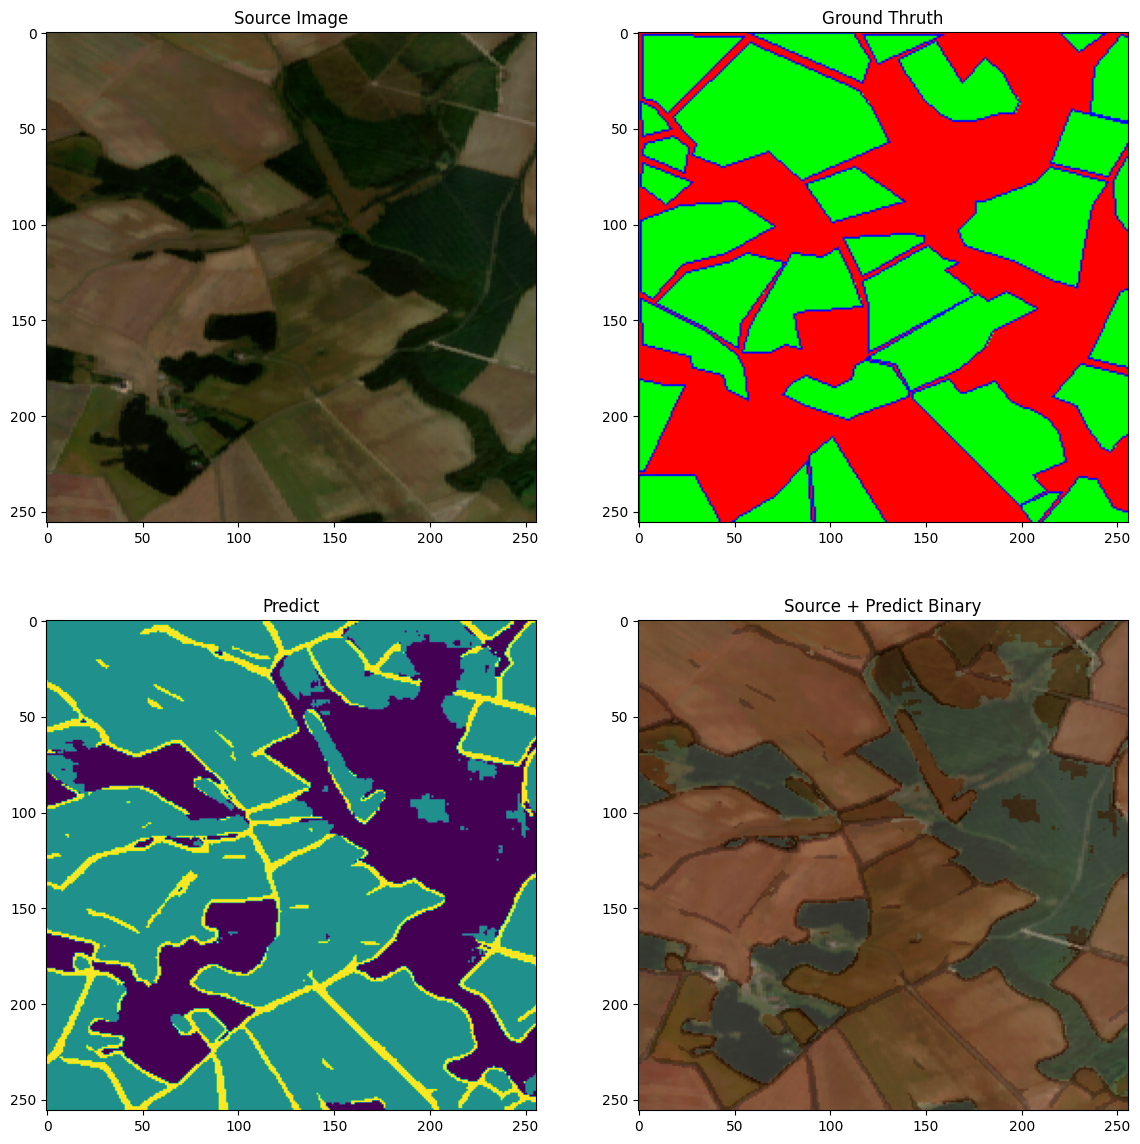

0 2


In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
ax = ax.flatten()
for images, labels in test_batches.skip(5):
    predict = model.predict(np.expand_dims(images[0], axis=0))
    predict = np.argmax(predict, axis=-1)
    predict = np.transpose(predict, (1, 2, 0))
    r = images[0, :, :, 3].numpy()
    g = images[0, :, :, 2].numpy()
    b = images[0, :, :, 1].numpy()
    img_filter = np.stack((r, g, b))
    img_filter = np.transpose(img_filter, (1, 2, 0))
    ax[0].imshow(img_filter)
    ax[0].set_title("Source Image")
    ax[1].imshow(labels[0].numpy(), cmap="Blues")
    ax[1].set_title("Ground Thruth")
    ax[2].imshow(predict)
    ax[2].set_title("Predict")
    ax[3].imshow(img_filter, alpha=1)
    ax[3].imshow(predict, alpha=.2, cmap="Reds")
    ax[3].set_title("Source + Predict Binary")
    plt.show()
    print(np.min(predict), np.max(predict))

In [28]:
model.save("models/seg_v6_3class_12feature.h5")